In [15]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten,Dropout,Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import utils
from tensorflow.keras import Model
import numpy as np
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.5.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH = '/content/drive/My Drive/Colab Notebooks/cats_and_dogs_filtered'
TRAIN_DIR = os.path.join(PATH, 'train_alltogether')

In [4]:
print ('This is a sample of the dataset file names')
print( os.listdir(TRAIN_DIR)[:5])

This is a sample of the dataset file names
['cat.4.jpg', 'cat.8.jpg', 'cat.5.jpg', 'cat.0.jpg', 'cat.1.jpg']


Visualize a sample of the image
Image shape: (308, 409, 3)


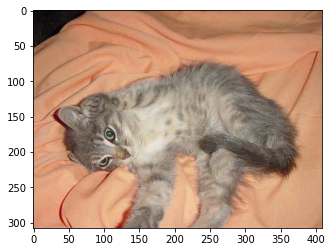

In [5]:
sample = plt.imread(os.path.join(TRAIN_DIR,random.choice(os.listdir(TRAIN_DIR))))
print ('Visualize a sample of the image')
print ('Image shape:',sample.shape)
plt.imshow(sample)

In [6]:
# Split data into train and validation sets (70% and 30% respectively)
f_train, f_valid = train_test_split(os.listdir(TRAIN_DIR), test_size=0.7, random_state=42)

In [7]:
# Network input size
PATCH_DIM = 32

In [16]:
# Build data generator that reads batch by batch from disk when needed
# src: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(utils.Sequence):
  'Generates data for Keras'
  def __init__(self, files, batch_size=32, dim=(224,224), n_channels=3, n_classes=2, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.files = files
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
  
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.files) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = np.random.choice(len(self.files), self.batch_size)

    # Find files of IDs
    batch_files = self.files[indexes]

    # Generate data
    X, y = self.__data_generation(batch_files)

    return X, y

  def __data_generation(self, batch_files):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, f in enumerate(batch_files):
      # Store sample
      img_path = os.path.join(TRAIN_DIR,f)
      img = image.load_img(img_path, target_size=self.dim)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      x = np.squeeze(x)
      X[i,:,:,:] = x

      # Store class
      if 'dog' in f:
        y[i]=1
      else:
        y[i]=0
                
    return X, y

In [17]:
training_generator = DataGenerator(np.array(f_train), dim=(PATCH_DIM, PATCH_DIM))

In [18]:
# Build and train the model
# Our model is reusing VGG16 architecture without the fully connected layers.
# So we used the weights from imagenet and add our head as shown
initial_model = VGG16(weights="imagenet", include_top=False, input_shape=(PATCH_DIM, PATCH_DIM, 3))
last = initial_model.output

x = Flatten()(last)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.4)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(initial_model.input, preds)
model.compile(Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

58892288/58889256 [==============================] - 0s 0us/step


In [19]:
# training of the model
model.fit_generator(generator=training_generator,
                    use_multiprocessing=True,
                    epochs=4,
                    workers=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
18/18 [==============================] - 47s 375ms/step - loss: 1.2751 - accuracy: 0.6319
Epoch 2/4
18/18 [==============================] - 2s 57ms/step - loss: 0.2961 - accuracy: 0.8663
Epoch 3/4
18/18 [==============================] - 2s 55ms/step - loss: 0.1282 - accuracy: 0.9497
Epoch 4/4
18/18 [==============================] - 2s 54ms/step - loss: 0.0579 - accuracy: 0.9774


In [20]:
# Read validation images and evaluate the model
X_val = np.empty((len(f_valid), PATCH_DIM, PATCH_DIM, 3))
y_val = np.empty((len(f_valid)), dtype=int)

for i, f in enumerate(f_valid):
    # Store sample
    img_path = os.path.join(TRAIN_DIR, f)
    img = image.load_img(img_path, target_size=(PATCH_DIM, PATCH_DIM))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = np.squeeze(x)
    X_val[i,:,:,:] = x

    # Store class
    if 'dog' in f:
        y_val[i]=1
    else:
        y_val[i]=0

In [21]:
y_pred = model.predict(X_val)
y_pred = [(y[0]>=0.5).astype(np.uint8) for y in y_pred]
print('Accuracy without TTA:',np.mean((y_val==y_pred)))

Accuracy without TTA: 0.6857142857142857


In [23]:
# use edafa (TTA package)

# Import the predictor suitable for your problem (ClassPredictor for Classification
# and SegPredictor for Segmentation)
#!pip install edafa
from edafa import ClassPredictor

In [24]:
# Inherit predictor class and implement the main function predict_patches(self,patches)

class OwnPredictor(ClassPredictor):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.model = model

    def predict_patches(self,patches):
        return self.model.predict(patches)

In [25]:
# Instantiate the class with configuration and whatever parameters needed

# use orignal image and flipped Left-Right images
# use arithmetic mean for averaging
conf = '{"augs":["NO", "FLIP_LR"], "mean":"ARITH"}'

In [26]:
p = OwnPredictor(model,conf)

/usr/local/lib/python3.7/dist-packages/edafa/BasePredictor.py:89: SyntaxWarning: No "bits" found in configuration file. 8-bits will be used.
  warnings.warn('No "bits" found in configuration file. 8-bits will be used.',SyntaxWarning)


In [27]:
# Predict images

y_pred_aug = p.predict_images(X_val)
y_pred_aug = [(y[0]>=0.5).astype(np.uint8) for y in y_pred_aug ]
print('Accuracy with TTA:', np.mean((y_val==y_pred_aug)))

Accuracy with TTA: 0.6828571428571428
